In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf

from scipy import ndimage, interpolate
from sklearn import manifold, cluster, decomposition, preprocessing

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

def get_MDS(filebase, bottle, mds_params):
    mds = dict()
    for key in bottle.keys():
        filename = filebase + '_' + key + '_MDS.csv' 
        if not os.path.isfile(filename):
            MDS = manifold.MDS(**mds_params).fit_transform(bottle[key])
            np.savetxt(filename, MDS, delimiter=',', fmt='%.6f')
        else:
            MDS = np.loadtxt(filename, delimiter=',')
        mds[key] = MDS
    return mds

In [3]:
fs = 16
N = 10
color = ['#009e73', '#f0e442', '#0072b2', '#cc79a7']
color = dict(zip(range(N*len(color)), np.tile(color,N)))
color[-1] = '#000000'

marker = ['D', 'o', 's', '^', 'v', 'P']
marker = dict(zip(range(N*len(marker)), np.tile(marker,N)))
marker[-1] = '*'

levels = ['sublevel', 'superlevel']
ksrc = '../kde/'
gsrc = '../gd_trans/'
sample = 'D2'
selection = 'all'
tsrc = gsrc + sample + '/'

ksrc += sample + os.sep
dst = '../distances/'
dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = sorted([foo.split('/')[-2] for foo in glob(ksrc + '*/')])
print(len(transcriptomes), 'transcriptomes')

wall = tf.imread('../cell_dams/' + sample + '_dams.tif').astype(bool)
wall[tf.imread('../nuclear_mask/' + sample + '_EDT.tif') < 2] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%50, axis=0)]

97 transcriptomes


In [4]:
foo = np.sum(transcell.iloc[:,1:-1] > 5, axis=1).sort_values(ascending=False)
transcell.loc[foo.index, ['gene']].join(foo.rename('num_cells')).head(25)

,gene,num_cells
26,GLYMA_05G092200,2870
62,GLYMA_12G027400,2327
2,BAC47034,1543
85,GLYMA_17G195900,1525
7,BAC52602,1246
77,GLYMA_16G039800,1086
84,GLYMA_17G185800,1008
57,GLYMA_11G008000,974
0,BAC45727,966
28,GLYMA_05G216000,831


In [5]:
tidx = 26
ddst = dst + transcriptomes[tidx] + os.sep
if not os.path.isdir(ddst):
    os.mkdir(ddst)

kdefiles = glob(ksrc + transcriptomes[tidx] + os.sep + '*.npy')
ratios = transcell.iloc[tidx, :-1].values.astype(float) / metatrans.loc[tidx, 'cyto_number']
metakde = np.zeros((len(kdefiles), 4), dtype=int)
rawkdemax = np.zeros(len(metakde))
for i in range(len(kdefiles)):
    foo = (os.path.splitext(os.path.split(kdefiles[i])[1])[0]).split('_')
    for j in range(metakde.shape[1]):
        metakde[i,j] = int(foo[j][1:])
    rawkdemax[i] = float(foo[-1][1:])
metakde = pd.DataFrame(metakde, columns=['ndimage_cellID', 'pad', 'stepsize', 'bandwidth'])
metakde['rawkdemax'] = rawkdemax
metakde['transnum'] = transcell.iloc[tidx, metakde['ndimage_cellID'].values].values.astype(int)
metakde['ratio_all'] = ratios[metakde['ndimage_cellID'].values]
metakde['ratio_select'] = metakde['transnum']/np.sum(metakde['transnum'])
metakde['kdemax_all'] = metakde['rawkdemax']*metakde['ratio_all']
metakde['kdemax_select'] = metakde['rawkdemax']*metakde['ratio_select']
metakde = metakde[metakde['ndimage_cellID'] != 0]

print(metakde.shape)

distance = 'bottleneck'
#distance = 'wasserstein1'
print('Working with',transcriptomes[tidx])

bottle = dict()
for key in levels:
    filename = tsrc + transcriptomes[tidx] + '_-_' + key + '_' + distance + '.csv'
    if not os.path.isfile(filename):
        N = 0
    else:        
        dflat = np.squeeze(pd.read_csv(filename, header=None).values)
        N = int(1 + np.sqrt(1 + 8*len(dflat)))//2
        A = np.zeros((N,N))
        A[np.triu_indices(N,k=1)] = dflat
        A += A.T
        bottle[key] = A
print('Working with',N,'cells')

jsonfiles = sorted(glob(tsrc + transcriptomes[tidx] + '/*' + key + '.json'))
cidxs = np.array([int(jsonfiles[i].split('_')[-4][1:]) for i in range(len(jsonfiles))])

mds_params = {'n_components':2, 'metric':True, 'random_state':42, 'dissimilarity':'precomputed', 'normalized_stress':False}
filebase = dst + transcriptomes[tidx] + '_' + distance 
mds = get_MDS(filebase, bottle, mds_params)


dbscan_params = {'eps':10, 'min_samples':3}
clust = dict()

for key in mds.keys():
    clust[key] = cluster.DBSCAN(**dbscan_params).fit(mds[key][:,:2])

(2870, 10)
Working with GLYMA_05G092200
Working with 2870 cells


In [6]:
meta = dict()
for key in levels:
    labs = clust[key].labels_
    ulabs, cts = np.unique(labs, return_counts=True)
    if -1 in ulabs:
        ulabs = np.hstack(([-1], ulabs[1:][np.argsort(cts[1:])[::-1]]))
    else:
        ulabs = ulabs[np.argsort(cts)[::-1]]
    meta[key] = {'labels': ulabs}
data = dict()
for key in mds.keys():
    data[key] = pd.DataFrame(mds[key], columns=['MDS1', 'MDS2'])
    labs = np.full_like(clust[key].labels_, min(meta[key]['labels']) - 1)
    for i,lab in enumerate(range(min(meta[key]['labels']), max(meta[key]['labels'])+1)):
        labs[clust[key].labels_ == lab] = meta[key]['labels'][i]
    
    data[key]['DBSCAN'] = labs
    
    scaler = preprocessing.StandardScaler().fit(mds[key][data[key]['DBSCAN'] > -1])
    train = scaler.transform(mds[key])
    #PCA = decomposition.KernelPCA(n_components=1, random_state=42, kernel='rbf', gamma=0.1).fit(train[data[key]['DBSCAN'] > -1])
    #PCA = decomposition.PCA(n_components=1, random_state=42, whiten=False).fit(train[data[key]['DBSCAN'] > -1])
    #colors = PCA.transform(train).squeeze()
    data[key]['PCA1'] = metakde.set_index('ndimage_cellID').loc[cidxs, 'kdemax_all'].values

    data[key]['ndimage_ID'] = cidxs
    data[key] = data[key].join(metacell.loc[cidxs, ['orig_cellID', 'orig_comX', 'orig_comY']].reset_index(drop=True))
    data[key] = data[key].iloc[:, [4,5,6,7,0,1,3,2]]

for key in meta:
    meta[key]['vmin'] = np.min(data[key][data[key]['DBSCAN'] > -1 ]['PCA1'])
    meta[key]['vmax'] = np.max(data[key][data[key]['DBSCAN'] > -1 ]['PCA1'])

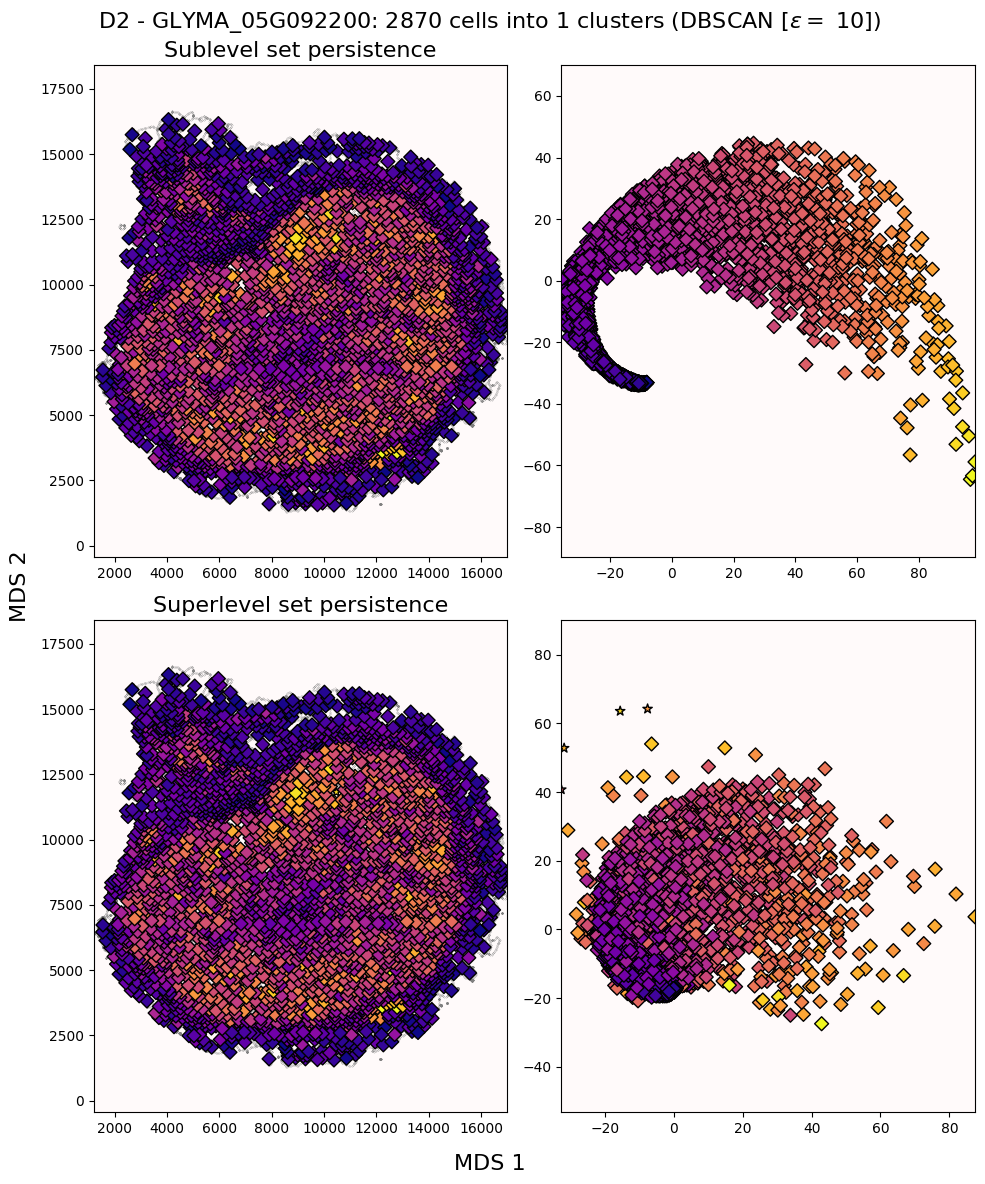

In [7]:
alpha = 1
fig, ax = plt.subplots(2,2, figsize=(10,12))
ax = np.atleast_1d(ax).ravel()

for i,key in enumerate(levels):
    ax[2*i].scatter(wc[1], wc[0], c='gray', marker='.', s=0.1, zorder=1, alpha=1)
    
    for j in range(len(meta[key]['labels'])):
        label = meta[key]['labels'][j]
        foo = data[key][data[key]['DBSCAN'] == label]
        ax[2*i].scatter(foo['orig_comX'], foo['orig_comY'], s=50, edgecolor='k',
                        vmax=meta[key]['vmax'], vmin=meta[key]['vmin'],
                      c=foo['PCA1'], marker=marker[label], cmap='plasma', alpha=alpha, zorder = label+3)
        ax[2*i+1].scatter(foo['MDS1'], foo['MDS2'], s=50, alpha=alpha, vmax=meta[key]['vmax'], vmin=meta[key]['vmin'],
                      c=foo['PCA1'], marker=marker[label], edgecolor='k', cmap='plasma')
        
    
    ax[2*i].set_title(key.title() + ' set persistence', fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].margins(0)
    ax[i].set_facecolor('snow')
    #ax[i].tick_params(labelbottom=False, labelleft=False)
    
fig.supxlabel('MDS 1', fontsize=fs)
fig.supylabel('MDS 2', fontsize=fs)

title = sample + ' - ' + transcriptomes[tidx]
title += ': {} cells into {} clusters (DBSCAN [$\\varepsilon = $ {}])'.format(len(kdefiles), len(ulabs)-1, dbscan_params['eps'])
fig.suptitle(title, fontsize=fs)

fig.tight_layout();

filename = dst + sample + '_-_' + transcriptomes[tidx] + '_-_' + distance + '_distance.jpg'
if not os.path.isfile(filename):
    plt.savefig(filename, format='jpg', dpi=96, bbox_inches='tight', pil_kwargs={'optimize':True})

In [8]:
idx = 0
vmax = np.max(metakde['kdemax_' + selection])
bins = np.linspace(0, vmax, 256)

key = 'sublevel'
psrt = data[key]['PCA1'].sort_values().index
cidx = cidxs[psrt[idx]]

def get_plot_info(idx):
    scatter = data[key].iloc[psrt[:idx+1], :].values
    cidx = int(scatter[-1,0])
    
    non = data[key].iloc[psrt[idx+1:], :].values
    kdemeta = metakde[metakde['ndimage_cellID'] == cidx]
    PP = kdemeta['pad'].iloc[0]
    stepsize = kdemeta['stepsize'].iloc[0]
    ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wallshape[0], metacell.loc[cidx, 'y1'] + PP])],
          np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wallshape[1], metacell.loc[cidx, 'x1'] + PP])])
    extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
    cy = ss[0].stop - ss[0].start
    cx = ss[1].stop - ss[1].start
    xaxis = np.arange(0, cx, stepsize); yaxis = np.arange(0, cy, stepsize)
    xaxis += ss[1].start; yaxis += ss[0].start
    kde = np.load(kdefiles[kdemeta.index[0]], allow_pickle=True)*kdemeta['ratio_' + selection].iloc[0]
    cp = cartesian_product(np.arange(yaxis[0],yaxis[-1]), np.arange(xaxis[0],xaxis[-1]))
    interp = interpolate.RegularGridInterpolator((yaxis, xaxis), kde, method='linear', bounds_error=True, fill_value=None)
    img = interp(cp)
    img = np.digitize(img, bins, right=True).astype(np.uint8).reshape(yaxis[-1]-yaxis[0],xaxis[-1]-xaxis[0])

    return scatter, non, img, extent

In [14]:
key = 'sublevel'
idx = 15
#for idx in range(len(kdefiles)):
for idx in range(20, len(kdefiles)):
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    ax = np.atleast_1d(ax).ravel()
    scatter, non, img, extent = get_plot_info(idx)
    cidx = int(scatter[-1,0])
    
    wmask = (wcoords[1] > extent[0]) & (wcoords[1] < extent[1]) & (wcoords[0] > extent[2]) & (wcoords[0] < extent[3])
    
    ax[0].scatter(wc[1], wc[0], c='darkgray', marker='.', s=0.1, zorder=1, alpha=1)
    ax[0].scatter(scatter[:-1,2], scatter[:-1,3], c = scatter[:-1,6], marker = 'D', cmap='plasma',
                  edgecolor='k', vmax=meta[key]['vmax'], vmin=meta[key]['vmin']);
    ax[0].scatter(scatter[-1,2], scatter[-1,3], c = 'lime', marker = 's', s=50, edgecolor='k');
    ax[1].scatter(scatter[:-1,4], scatter[:-1,5], c = scatter[:-1,6], marker = 'D', cmap='plasma',
                  edgecolor='k', vmax=meta[key]['vmax'], vmin=meta[key]['vmin']);
    ax[1].scatter(non[:,4], non[:,5], alpha=0, marker='D')
    ax[1].scatter(scatter[-1,4], scatter[-1,5], c = 'lime', marker = 's', s=50, edgecolor='k');
    
    ax[2].imshow(img, cmap='plasma', origin='lower', vmin=0, vmax=255, extent=extent)
    ax[2].set_xlim((extent[0], extent[1])); ax[2].set_ylim((extent[2], extent[3]))
    ax[2].scatter(wcoords[1, wmask], wcoords[0, wmask], c='darkgray', marker='.', s=1, zorder=2, alpha=1)
    
    for i in range(len(ax)):
        ax[i].set_aspect('equal', 'datalim');
        ax[i].set_facecolor('snow')
        ax[i].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

    ax[0].set_title(sample + ' - ' + transcriptomes[tidx], fontsize=fs)
    ax[1].set_title('{} cells in total'.format(len(kdefiles)), fontsize=fs)
    ax[2].set_title('Cell ID {} [{}]'.format(metacell.loc[cidx, 'orig_cellID'], cidx), loc='left', fontsize=fs)

    ax[0].set_xlabel('Nodal cross section', fontsize=fs)
    ax[1].set_xlabel('MDS of {} distance'.format(distance), fontsize=fs)
    ax[2].set_xlabel('KDE and {} pers.'.format(key), fontsize=fs)
    
    fig.tight_layout()
    
    filename = ddst + transcriptomes[tidx] + '_-_{}_{}_{:05d}_c{}.png'.format(key, distance, idx, cidx)
    plt.savefig(filename, format='png', dpi=96, bbox_inches='tight')
    plt.close()

In [10]:
filename = ddst + transcriptomes[tidx] + '_-_{}_{}_{:05d}_c{}.png'.format(key, distance, idx, cidx)
filename

'../distances/D2/GLYMA_05G092200/GLYMA_05G092200_-_sublevel_bottleneck_00365_c2201.png'

In [11]:
title = sample + ' - ' + transcriptomes[tidx]
title += ': Cell {} [{}]. Total of {} cells ({} persistence [H$_0$ and H$_1$])'.format(metacell.loc[cidxs[psrt[idx]], 'orig_cellID'], cidxs[psrt[idx]], len(kdefiles), key)
title

'D2 - GLYMA_05G092200: Cell 2203 [2201]. Total of 2870 cells (sublevel persistence [H$_0$ and H$_1$])'